Scanpy is a scalable toolkit for analyzing single-cell gene expression data. It includes methods for preprocessing, visualization, clustering, pseudotime and trajectory inference, differential expression testing, and simulation of gene regulatory networks. This tutorial is largely adapted from the original tutorials which can be found in Scanpy's [read the docs](https://scanpy.readthedocs.io/en/stable/) and from [this](https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=533160543ee890ef3fad377a21a1ba45cda65882&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f416363696f2f616e616c7973696e672d7363524e417365712d776974682d7363616e70792d616e642d62657363612f353333313630353433656538393065663366616433373761323161316261343563646136353838322f7363616e70792d7475746f7269616c2d336b50424d432e6970796e62&logged_in=false&nwo=Accio%2Fanalysing-scRNAseq-with-scanpy-and-besca&path=scanpy-tutorial-3kPBMC.ipynb&platform=android&repository_id=262068634&repository_type=Repository&version=98) notebook. 

Make sure you've installed Scanpy:

In [1]:
%conda install -c conda-forge scanpy python-igraph leidenalg

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [19]:
sc.settings.verbosity = 3   # verbosity: errors (0), warnings (1), info (2), hints (3)

In [5]:
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.1.1
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.0
cloudpickle         2.1.0
colorama            0.4.5
cycler              0.10.0
cython_runtime      NA
dask                2022.6.1
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           0.8.3
fsspec              2022.5.0
google              NA
h5py                3.7.0
hypergeom_ufunc     NA
ipykernel           6.13.1
ipython_genutils    0.2.0
jedi                0.18.1
jinja2              3.1.2
joblib              1.1.0
jupyter_server      1.17.1
kiwisolver          1.4.2
llvmlite            0.38.1
markupsafe          2.1.1
matplotlib          3.5.2
mpl_toolkits        NA
natsort             8.1.0
nbinom_ufunc        NA
numba               0.55.2
numpy               1.22.4
pa

In [3]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

--2022-07-22 15:12:13--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2022-07-22 15:12:13--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  --.-KB/s    in 0.1s    

2022-07-22 15:12:13 (49.2 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’ saved [7621991

In [4]:
results_file = 'write/pbmc3k.h5ad' # the file that will store the analysis results

In [20]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


See [anndata-tutorials/getting-started] for a more comprehensive introduction to AnnData.

In [21]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [10]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

# Pre-processing

## Check for highly expressed genes

Show genes that yield the highest fraction of counts in each single cell, across all cells. The `sc.pl.highest_expr_genes` command normalizes counts per cell, and plots the genes that are most abundant in each cell.

normalizing counts per cell
    finished (0:00:00)


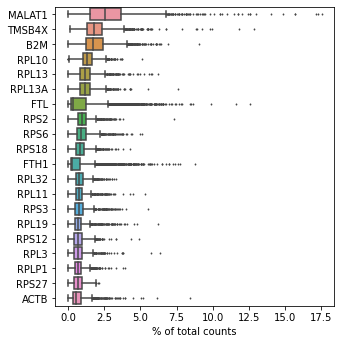

In [22]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Note that MALAT1, a non-coding RNA that is known to be extremely abundant in many cells, ranks at the top.

## Basic filtering: remove cells and genes with low expression or missing values.

In [23]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


## Check mitochondrial genes for Quality Control

Let’s assemble some information about mitochondrial genes, which are important for quality control.

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [24]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

- the number of genes expressed in the count matrix
- the total counts per cell
- the percentage of counts in mitochondrial genes

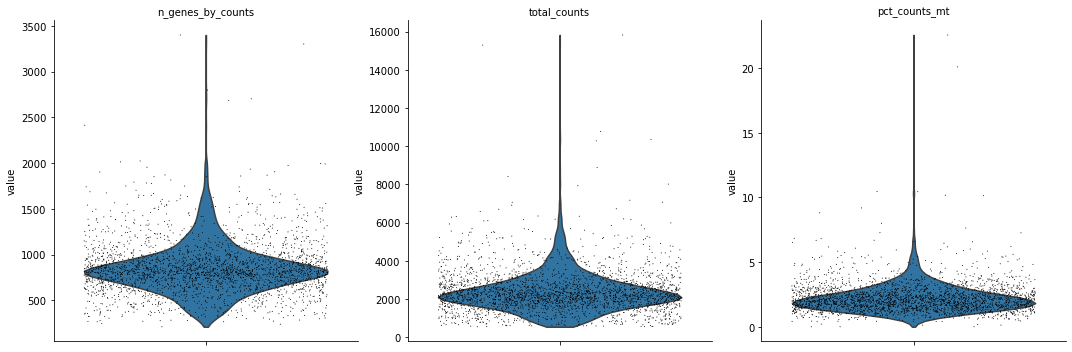

In [25]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts. High proportions of mitochondrial genes indicate poor-quality cells, potentially because of loss of cytoplasmic RNA from perforated cells.

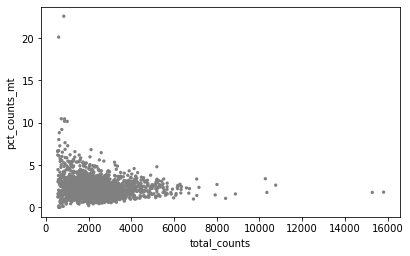

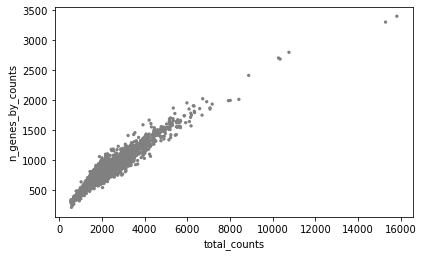

In [26]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

## Filter data based on QC
Check current datset and filter it by slicing the AnnData object.

In [27]:
print(adata)

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [28]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
print(adata)

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


## Data normalization
To correct differences in library sizes across cells, normalize the total read count of the data matrix to 10,000 reads per cell so that counts become comparable among cells.

In [29]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/Users/paulinampaiz/opt/anaconda3/envs/deepchem/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Log transform the data for later use in differential gene expression as well as in visualizations. The natural logarithm is used, and `log1p` means that an extra read is added to cells of the count matrix as a pseudo-read. See [here](https://www.biogazelle.com/seven-tips-bio-statistical-analysis-gene-expression-data) for more information on why log scale makes more sense for genomic data. 

In [30]:
sc.pp.log1p(adata)

## Identify highly-variable genes.
The function `sc.pp.highly_variable_genes` can detect marker genes that can help us identify cells based on a few manually set parameters, including mininum mean expression, maximum mean expression, and minimum dispersion. We will focus our analysis on such genes. 

In [31]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


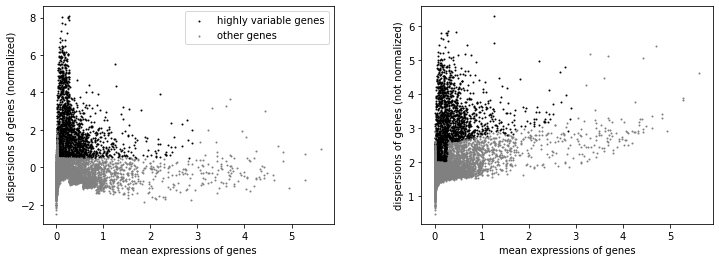

In [32]:
sc.pl.highly_variable_genes(adata)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [33]:
adata.raw = adata

Filter the `adata` object so that only genes that are highly variable are kept.

In [34]:
adata = adata[:, adata.var.highly_variable]

## Correct for the effects of counts per cell and mitochondrial gene expression

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. This can consume some memory and take some time because the input data is sparse. 

In [35]:
sc.pp.regress_out(adata, ['n_genes_by_counts', 'pct_counts_mt'])

regressing out ['n_genes_by_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)


## Center the data to zero and scale to unit variance

Use `sc.pp.scale` to center the average expression per gene to zero. Here we are also clipping scaled values that exceed standard deviation of 10.

In [36]:
sc.pp.scale(adata, max_value=10)

## Dimension reduction with PCA

We first use principal component analysis (PCA), a linear dimention-reduction technique, to reveal the main axes of variation and denoise the data.

In [37]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

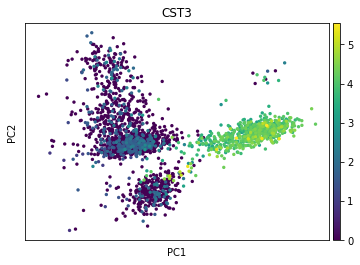

In [38]:
sc.pl.pca(adata, color="CST3")

The variance ratio plot lists contributions of individual principal components (PC) to the total variance in the data. This piece of information helps us to choose an appropriate number of PCs in order to compute the neighborhood relationships between the cells, for instance, using the clustering method Louvain `sc.tl.louvain()` or the embedding method tSNE `sc.tl.tsne()` for dimension-reduction.

According to the authors of Scanpy, a rough estimate of the number of PCs does fine.

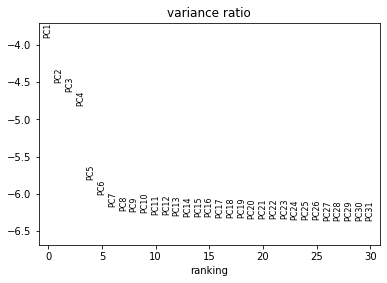

In [39]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result up to PCA analysis.

In [40]:
! mkdir -p write
adata.write(results_file)

Note that our adata object has following elements: observations annotation (obs), variables (var), unstructured annotation (uns), multi-dimensional observations annotation (obsm), and multi-dimensional variables annotation (varm). The meanings of these parameters are documented in the anndata package, available at [anndata documentation](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html).

In [41]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing and Embedding the neighborhood graph

Use the PCA representation of the data matrix to compute the neighborhood graph of cells. 

In [42]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40


/Users/paulinampaiz/opt/anaconda3/envs/deepchem/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

: 

The auhours of Scanpy suggest embedding the graph in two dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)). UMAP is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. 

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the `.raw` attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use `.raw`.

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

In [ ]:
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://arxiv.org/abs/1810.08473). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section. Compared with the Louvain algorithm, the Leiden algorithm yields communities that are guaranteed to be connected. When applied iteratively, the Leiden algorithm converges to a partition in which all subsets of all communicities are locally optimally assigned. Last but not least, it runs faster.

In [ ]:
sc.tl.leiden(adata)

Plot the clusters using `sc.pl.umap`. Note that the color parameter accepts both individual genes and the clustering method (leiden in this case).

In [ ]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

We save the result again.

In [ ]:
adata.write(results_file)

## Identifying marker genes

Compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test. Other methods include Wilcoxon rank-sum (Mann-Whitney-U) test, MAST, limma, DESeq2, and diffxpy by the Theis lab. The authours of Scanpy reccomend using the Wilcoxon rank-sum test in publications.

## The Wilcoxon's test

For simplicity, we start with the Mann-Whitney-U test. The null hypothesis is that the rank of a gene in a cluster is the same as its rank in all cells. The alternative hypothesis is that the rank of a gene in a cluster is much higher than its rank in all cells (one-sided). The function `sc.tl.rank_genes_groups` performs the test, and `sc.pl.rank_genes_groups` plots the top genes.

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

In [ ]:
adata.write(results_file)

## The Student's t-test

An alternative to the non-parametric Wilcoxon test is the t-test.

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by Natranos et al. (2018). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method="logreg")
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

Let us also define a list of marker genes for later reference.

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

## Listing signatures using the results of the Wilcoxon's test

We use the results of the Wilcoxon's test for downstream analysis. Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [ ]:
adata = sc.read(results_file)

NameError: name 'sc' is not defined

Show the 10 top ranked genes per cluster 0, 1, …, 7 in a dataframe.

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

Get a table with the scores and groups.

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

Compare to a single cluster:

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Actually mark the cell types.

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)


In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

There is also a very compact violin plot.

In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

During the course of this analysis, the AnnData accumlated the following annotations.